<a href="https://colab.research.google.com/github/aetev/Learning-stuff-/blob/main/GET%20REAl%202.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install pandas_ta
!pip install tf_agents[reverb]
!pip install seaborn

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 3108, in _dep_map
    return self.__dep_map
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 2901, in __getattr__
    raise AttributeError(attr)
AttributeError: _DistInfoDistribution__dep_map

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/base_command.py", line 169, in exc_logging_wrapper
    status = run_func(*args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/req_command.py", line 242, in wrapper
    return func(self, options, args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/commands/install.py", line 441, in run
    conflicts = self._determine_conflicts(to_install)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/commands/install.py", line 

In [3]:
pip install line_profiler

ERROR: Operation cancelled by user


In [1]:

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [2]:
import pandas as pd
import numpy as np
import pandas_ta as ta
import matplotlib.pyplot as plt
import reverb
import random
import seaborn as sns

import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.keras import layers
from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import py_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import sequential
from tf_agents.policies import py_tf_eager_policy
from tf_agents.policies import epsilon_greedy_policy
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import reverb_replay_buffer
from tf_agents.replay_buffers import reverb_utils
from tf_agents.trajectories import trajectory
from tf_agents.specs import tensor_spec
from tf_agents.utils import common
from tf_agents.policies import greedy_policy
from tf_agents.policies.epsilon_greedy_policy import EpsilonGreedyPolicy
from tf_agents.drivers import dynamic_episode_driver
from tf_agents.drivers.dynamic_step_driver import DynamicStepDriver
from tf_agents.environments.batched_py_environment import BatchedPyEnvironment
from tf_agents.networks import categorical_q_network
from tf_agents.agents.categorical_dqn import categorical_dqn_agent

from tf_agents.environments import py_environment
from tf_agents.environments import tf_environment
from tf_agents.environments import tf_py_environment
from tf_agents.environments import utils
from tf_agents.specs import array_spec
from tf_agents.environments import wrappers
from tf_agents.environments import suite_gym
from tf_agents.trajectories import time_step as ts

In [3]:
try:
    # Disable all GPUS
    tf.config.set_visible_devices([], 'GPU')
    visible_devices = tf.config.get_visible_devices()
    for device in visible_devices:
        assert device.device_type != 'GPU'
except:
    # Invalid device or cannot modify virtual devices once initialized.
    pass


In [4]:
num_iterations = 20000000 # @param {type:"integer"}

initial_collect_steps = 100  # @param {type:"integer"}
collect_steps_per_iteration =   1# @param {type:"integer"}
replay_buffer_max_length = 100000  # @param {type:"integer"}

batch_size = 64  # @param {type:"integer"}
learning_rate = 1e-3  # @param {type:"number"}
log_interval = 1000  # @param {type:"integer"}

num_eval_episodes = 3  # @param {type:"integer"}
eval_interval = 100000  # @param {type:"integer"}

In [5]:
def get_relative_change(df, column_name):
    relative_changes = []
    for i in range(len(df)):
        if i == 0:
            relative_changes.append(0)  # First element has no previous value
        else:
            relative_change = (df.iloc[i] - df.iloc[i-1]) / df.iloc[i-1]
            relative_changes.append(relative_change)
    return pd.DataFrame({column_name: relative_changes})

In [6]:
df = pd.read_csv('/content/drive/MyDrive/eurusd_hour.csv')
close = df['AC']
open = df['AO']
high = df['AH']
low = df['AL']
achange = df['ACh']
print(df)

             Date   Time       BO       BH       BL       BC      BCh  \
0      2005-05-02  00:00  1.28520  1.28520  1.28400  1.28440 -0.00080   
1      2005-05-02  01:00  1.28440  1.28480  1.28390  1.28420 -0.00020   
2      2005-05-02  02:00  1.28430  1.28540  1.28410  1.28510  0.00080   
3      2005-05-02  03:00  1.28510  1.28590  1.28500  1.28510  0.00000   
4      2005-05-02  04:00  1.28520  1.28590  1.28490  1.28550  0.00030   
...           ...    ...      ...      ...      ...      ...      ...   
93079  2020-04-29  18:00  1.08620  1.08851  1.08611  1.08713  0.00093   
93080  2020-04-29  19:00  1.08711  1.08823  1.08659  1.08748  0.00037   
93081  2020-04-29  20:00  1.08747  1.08788  1.08691  1.08708 -0.00039   
93082  2020-04-29  21:00  1.08708  1.08740  1.08699  1.08714  0.00006   
93083  2020-04-29  22:00  1.08728  1.08760  1.08727  1.08743  0.00015   

            AO       AH       AL       AC      ACh  
0      1.28540  1.28540  1.28420  1.28460 -0.00080  
1      1.28460  1

In [7]:
RSI = ta.rsi(close,14,scalar=1)
AROON = ta.aroon(high,low,14,scalar = 1)
AROON_UP = AROON['AROOND_14']
AROON_DOWN = AROON['AROONU_14']
CCI = ta.cci(high,low,close,14)
CCI = CCI.multiply(.001)
CCI = CCI.add(.5)
RVI = ta.rvi(close,high,low,14,scalar=1)
CHANGE = achange
CHANGE.name = 'Change'
lookback = 10
DIFF_enter = ta.sma(achange/np.std(achange),lookback,offset = -lookback)
DIFF_enter.name = 'DIFF_enter'

DIFF_hold = ta.sma(achange/np.std(achange),lookback,offset = -(lookback/2))
DIFF_hold.name = 'DIFF_hold'

INDICATORS = pd.concat([CHANGE,RSI,AROON_UP,AROON_DOWN,CCI,RVI,DIFF_enter,DIFF_hold],axis=1)

INDICATORS = INDICATORS.dropna(axis=0)
INDICATORS = INDICATORS.reset_index()

change = INDICATORS.pop('Change')
DIFF_enter = INDICATORS.pop('DIFF_enter')
DIFF_hold = INDICATORS.pop('DIFF_hold')
INDICATORS.pop('index')

INDICATORS = INDICATORS.to_numpy()
change = change.to_numpy()
change_dev = change.std()
change = change/change_dev
np.set_printoptions(suppress=True)

In [8]:
print(np.min(DIFF_hold))

-2.6356777988352724


(5400.0, 5500.0)

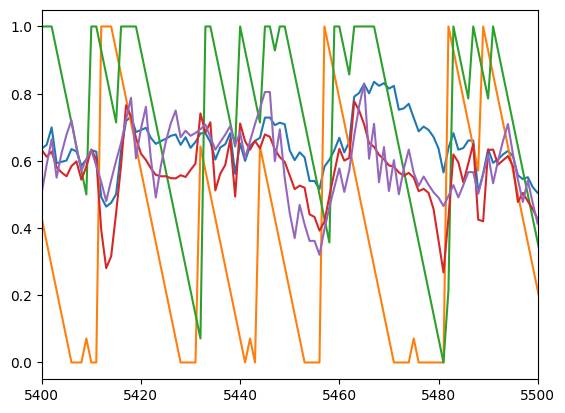

In [9]:
plt.plot(INDICATORS)
plt.xlim(5400,5500)
#print(INDICATORS)

In [10]:
def custom_formatter(x):
  return f'{x:.4f}'


def test_environment(env, num_steps):
    # Reset the environment
    observation = env.reset()

    # Get the upper bound of the action range
    action_spec = env.action_spec().maximum

    # Loop through the time steps and take random actions
    for _ in range(num_steps):
        # Select a random action from the range of valid values
        action = random.randint(0, action_spec)

        # Execute the action and get the next observation, reward, done, and info
        observation, reward, done, info = env.step(action)

        # Print the current time step
        np.set_printoptions(formatter={'float_kind':custom_formatter})
        print(action,"{:.4f}".format(reward),info[5:12])


In [11]:
def cross(cur_diff,prev_diff):
  if cur_diff > 0 and prev_diff <= 0:
    return 5
  elif cur_diff < 0 and prev_diff >= 0:
    return 5
  else:
    return 0


In [12]:
max_ep_len = 48

In [13]:
def SortinoRatio(df, T):
    """Calculates the Sortino ratio from univariate excess returns.


    Args:
        df ([float]): The dataframe or pandas series of univariate excess returns.
        T ([integer]): The targeted return.
    """

    #downside deviation:

    #temp = np.minimum(0, df - T)**2
    temp = np.square(np.minimum(0, df - T))
    temp_expectation = np.mean(temp)
    downside_dev = np.sqrt(temp_expectation)

    if downside_dev == 0:
      return 0

    #Sortino ratio:

    sortino_ratio = np.mean(df - T) / downside_dev

    return(sortino_ratio)

In [14]:
%load_ext line_profiler

In [15]:
df = np.random.normal(loc=0, scale=1, size=100)
T = 0

In [16]:
%lprun -f SortinoRatio SortinoRatio(df,T)

In [17]:
actions = {
    0: lambda cur_change: {
        'value': cur_change,
        'direction': 1,
        #'time': 0,
        'max_val': cur_change,
        'min_val': cur_change,
        #'max_time': 0,
        #'min_time': 0
    },
    1: lambda cur_change: {
        'value': -cur_change,
        'direction': -1,
        #'time': 0,
        'max_val': -cur_change,
        'min_val': -cur_change,
        #'max_time': 0,
        #'min_time': 0
    },
    2: lambda cur_change: {
        'value': 0,
        'direction': 0,
        #'time': 0,
        'max_val': 0,
        'min_val': 0,
        #'max_time': 0,
        #'min_time': 0
    }
    }

In [18]:
class TradingEnv(py_environment.PyEnvironment):

  def __init__(self):
    self._action_spec = array_spec.BoundedArraySpec(
        shape=(), dtype=np.int64, minimum=0, maximum=3, name='action')
    self._observation_spec = array_spec.BoundedArraySpec(
        shape=(9,), dtype=np.float32, minimum=-100,maximum=100, name='observation')


    self._state = np.zeros(9)
    self._episode_ended = False
    self._count = random.randint(10000,60000)
    self._end_ep = self._count+max_ep_len
    self._balance = 0
    self._returns = np.zeros(0)
    self.trade_info = {
    #'time': 0,
    'value': 0,
    'direction': 0,
    'max_val': 0,
    'min_val': 0,
    #'max_time': 0,
    #'min_time': 0
    }


  def action_spec(self):
    return self._action_spec

  def observation_spec(self):
    return self._observation_spec

  def get_balance(self):
    return self._balance

  def _reset(self):

    self._state = np.zeros(9)
    self._episode_ended = False
    self._count = random.randint(10000,60000)
    self._end_ep = self._count+max_ep_len
    self._returns = np.zeros(0)
    self._balance = 0
    self.trade_info = {
    #'time': 0,
    'value': 0,
    'direction': 0,
    'max_val': 0,
    'min_val': 0,
    #'max_time': 0,
    #'min_time': 0
    }

    return ts.restart(np.array(self._state, dtype=np.float32))

  def _step(self, action):

    if self._episode_ended:
      # The last action ended the episode. Ignore the current action and start
      # a new episode.
      return self.reset()


    mult = 10
    diff_hold = DIFF_hold[self._count]
    profit = 0
    reward = 0
    cur_change = change[self._count+1]/mult
    cur_direction = self.trade_info['direction']
    action_func = actions.get(int(action), None)

    if action_func:
      profit = self.trade_info['value']
      reward = profit if profit >= 0 else min(-profit-.1,0)
      action_details = action_func(cur_change)
      self.trade_info.update(action_details)
    else:
      self.trade_info['value'] += cur_change * cur_direction
      #self.trade_info['time'] += 0.01 if cur_direction != 0 else 0
      self.trade_info['max_val'] = max(self.trade_info['value'], self.trade_info['max_val'])
      self.trade_info['min_val'] = min(self.trade_info['value'], self.trade_info['min_val'])
      #self.trade_info['max_time'] = 0 if self.trade_info['max_val'] == self.trade_info['value'] else self.trade_info['max_time'] + 0.01
      #self.trade_info['min_time'] = 0 if self.trade_info['min_val'] == self.trade_info['value'] else self.trade_info['min_time'] + 0.01
      #reward = diff_hold*cur_direction


    self._balance += profit
    if profit != 0:
        self._returns = np.append(self._returns, profit)

    #info_list = np.fromiter(self.trade_info.values(), dtype=float)
    info_list = list(self.trade_info.values())

    #update state
    self._state = np.append(INDICATORS[self._count],info_list)

    if self._count >= self._end_ep:
      self._episode_ended = True
      if self.trade_info['value']<0:
        np.append(self._returns,self.trade_info['value'])

    self._count += 1

    if self._episode_ended:

      reward = SortinoRatio(self._returns,0) if np.sum(self._returns) != 0 else -10
      return ts.termination(np.array(self._state, dtype=np.float32), reward=reward)
    else:
      return ts.transition(
          np.array(self._state, dtype=np.float32), reward=reward, discount=.99)

In [19]:
env = TradingEnv()


utils.validate_py_environment(env, episodes=2)

In [20]:
train_py_env = env
eval_py_env = env
train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

In [21]:
import timeit

In [22]:
timeit_result = timeit.timeit(lambda: test_environment(env, 1000), number=10)
print(timeit_result)

Streaming output truncated to the last 5000 lines.
3 0.0000 [0.1346 -1.0000 0.1346 0.0388]
3 0.0000 [0.1533 -1.0000 0.1533 0.0388]
2 0.1533 [0.0000 0.0000 0.0000 0.0000]
1 0.0000 [-0.0213 -1.0000 -0.0213 -0.0213]
2 -0.0787 [0.0000 0.0000 0.0000 0.0000]
0 0.0000 [-0.0142 1.0000 -0.0142 -0.0142]
1 -0.0858 [0.0453 -1.0000 0.0453 0.0453]
0 0.0453 [-0.3099 1.0000 -0.3099 -0.3099]
0 0.0000 [-0.0226 1.0000 -0.0226 -0.0226]
0 -0.0774 [0.0796 1.0000 0.0796 0.0796]
2 0.0796 [0.0000 0.0000 0.0000 0.0000]
3 0.0000 [0.0000 0.0000 0.0000 0.0000]
1 0.0000 [0.0369 -1.0000 0.0369 0.0369]
0 0.0369 [0.0272 1.0000 0.0272 0.0272]
0 0.0272 [-0.0336 1.0000 -0.0336 -0.0336]
3 0.0000 [0.0091 1.0000 0.0091 -0.0336]
2 0.0091 [0.0000 0.0000 0.0000 0.0000]
1 0.0000 [-0.0653 -1.0000 -0.0653 -0.0653]
0 -0.0347 [-0.0155 1.0000 -0.0155 -0.0155]
0 -0.0845 [0.0201 1.0000 0.0201 0.0201]
3 0.0000 [0.0479 1.0000 0.0479 0.0201]
0 0.0479 [0.0343 1.0000 0.0343 0.0343]
1 0.0343 [-0.0944 -1.0000 -0.0944 -0.0944]
3 0.0000 [-0.15

In [23]:
print('Action Spec:')
print(env.action_spec())

Action Spec:
BoundedArraySpec(shape=(), dtype=dtype('int64'), name='action', minimum=0, maximum=3)


In [24]:
fc_layer_params = (20, 5)
action_tensor_spec = tensor_spec.from_spec(env.action_spec())
num_actions = action_tensor_spec.maximum - action_tensor_spec.minimum + 1


In [25]:
def activity_regularizer(multiplier, decay=0.99):
    # Initialize moving averages for mean and variance
    mean_avg = tf.Variable(0.0, trainable=False, name='mean_avg')
    variance_avg = tf.Variable(1.0, trainable=False, name='variance_avg')

    def regularizer(y_pred):
        # Calculate the current mean and variance
        current_mean = tf.reduce_mean(y_pred)
        current_variance = tf.math.reduce_variance(y_pred)

        # Update moving averages
        update_mean = tf.compat.v1.assign(mean_avg, decay * mean_avg + (1 - decay) * current_mean)
        update_variance = tf.compat.v1.assign(variance_avg, decay * variance_avg + (1 - decay) * current_variance)

        with tf.control_dependencies([update_mean, update_variance]):
            # Use the moving averages for regularization
            mean = mean_avg
            variance = variance_avg

        return multiplier * (tf.square(mean - 0) + tf.square(variance - 1))

    return regularizer

In [26]:


#import base64
#import imageio
import matplotlib
import matplotlib.pyplot as plt

import tensorflow as tf

from tf_agents.agents.dqn.dqn_agent import DqnAgent, DdqnAgent
from tf_agents.networks.q_network import QNetwork

from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment

from tf_agents.policies.random_tf_policy import RandomTFPolicy
from tf_agents.replay_buffers.tf_uniform_replay_buffer import TFUniformReplayBuffer
from tf_agents.trajectories import trajectory
from tf_agents.utils import common

# Globals
NUMBER_EPOSODES = 1000000
COLLECTION_STEPS = 1
BATCH_SIZE = 32
EVAL_EPISODES = 3
EVAL_INTERVAL = 1000



In [27]:
print('Observation Spec:')
print(train_env.time_step_spec().observation)

print('Reward Spec:')
print(train_env.time_step_spec().reward)

print('Action Spec:')
print(train_env.action_spec())

train_env = tf_py_environment.TFPyEnvironment(env)
evaluation_env = tf_py_environment.TFPyEnvironment(env)

Observation Spec:
BoundedTensorSpec(shape=(9,), dtype=tf.float32, name='observation', minimum=array(-100.0000, dtype=float32), maximum=array(100.0000, dtype=float32))
Reward Spec:
TensorSpec(shape=(), dtype=tf.float32, name='reward')
Action Spec:
BoundedTensorSpec(shape=(), dtype=tf.int64, name='action', minimum=array(0), maximum=array(3))


In [28]:
from tf_agents.networks import network


class CustomQNetwork(network.Network):
    def __init__(self, input_tensor_spec, action_spec, name='CustomQNetwork'):
        super(CustomQNetwork, self).__init__(input_tensor_spec=input_tensor_spec,
                                             state_spec=(),
                                             name=name)
        # Define your custom layers and architecture here
        self.dense1 = layers.Dense(20,activation='gelu', activity_regularizer=activity_regularizer(0.01))
        self.drop1 = layers.Dropout(.2)
        self.dense2 = layers.Dense(4,activation='gelu', activity_regularizer=activity_regularizer(0.01))
        self.drop2 = layers.Dropout(.01)
        self.dense3 = layers.Dense(10,activation='gelu', activity_regularizer=activity_regularizer(0.01))
        self.drop3 = layers.Dropout(.1)
        self.q_values_layer = tf.keras.layers.Dense(action_spec.maximum - action_spec.minimum + 1,
                                                    activation=None)

    def call(self, observation, step_type=None, network_state=(), training=False):
        # Pass the observation through your custom layers
        x = self.dense1(observation)
        x = self.drop1(x)
        x = self.dense2(x)
        x = self.drop2(x)
        x = self.dense3(x)
        x = self.drop3(x)

        q_values = self.q_values_layer(x)
        return q_values, network_state

In [29]:

class CategoricalQNetwork(network.Network):
    def __init__(self, input_tensor_spec, action_spec, num_atoms=51,name='CategoricalQNetwork'):
        super(CategoricalQNetwork, self).__init__(input_tensor_spec=input_tensor_spec,
                                                  state_spec=(),
                                                  name=name)
        # Check if action_spec is a BoundedTensorSpec
        if not isinstance(action_spec, tensor_spec.BoundedTensorSpec):
            raise TypeError('action_spec must be a BoundedTensorSpec. Got: %s' % (action_spec,))

        self._num_actions = action_spec.maximum - action_spec.minimum + 1
        self._num_atoms = num_atoms

        # Create a BoundedTensorSpec for the q_network action
        q_network_action_spec = tensor_spec.BoundedTensorSpec((), tf.int32,
                                                              minimum=0,
                                                              maximum=self._num_actions * num_atoms - 1)

        # Create the q_network
        self._q_network = CustomQNetwork(input_tensor_spec=input_tensor_spec,
                                             action_spec=q_network_action_spec,
                                             )
    def call(self, observation, step_type=None, network_state=(), training=False):
        logits, network_state = self._q_network(observation, step_type, network_state, training=training)
        logits = tf.reshape(logits, [-1, self._num_actions, self._num_atoms])
        return logits, network_state
    @property
    def num_atoms(self):
        return self._num_atoms

In [30]:
observation_spec = train_env.observation_spec()  # Specify the input tensor spec for your network
action_spec = train_env.action_spec()
num_atoms = 10
dropout_rate = 0.2
custom_network = CategoricalQNetwork(observation_spec,action_spec, num_atoms)

In [31]:
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)

train_step_counter = tf.Variable(0)

agent = categorical_dqn_agent.CategoricalDqnAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    categorical_q_network=custom_network,
    optimizer=optimizer,
    min_q_value=-3,
    max_q_value=3,
    n_step_update=2,
    td_errors_loss_fn=common.element_wise_squared_loss,
    epsilon_greedy = .1,
    gamma=1,
    train_step_counter=train_step_counter)
agent.initialize()


In [32]:

def get_average_reward(environment, policy, episodes=10):

    total_reward = 0.0

    for _ in range(episodes):
        time_step = environment.reset()
        episode_reward = 0.0

    while not time_step.is_last():
        action_step = policy.action(time_step)
        time_step = environment.step(action_step.action)
        episode_reward += time_step.reward

    total_reward += episode_reward
    avg_reward = total_reward / episodes

    return avg_reward.numpy()[0]



In [33]:
class ExperienceReplay(object):
    def __init__(self, agent, enviroment):
        self._replay_buffer = TFUniformReplayBuffer(
            data_spec=agent.collect_data_spec,
            batch_size=enviroment.batch_size,
            max_length=10000)

        self._random_policy = RandomTFPolicy(train_env.time_step_spec(),
                                                enviroment.action_spec())

        self._fill_buffer(train_env, self._random_policy, steps=100)

        self.dataset = self._replay_buffer.as_dataset(
            num_parallel_calls=tf.data.AUTOTUNE,
            sample_batch_size=BATCH_SIZE,
            num_steps=2).prefetch(tf.data.AUTOTUNE)

        self.iterator = iter(self.dataset)



    def _fill_buffer(self, enviroment, policy, steps):
        for _ in range(steps):
            self.timestamp_data(enviroment, policy)

    def timestamp_data(self, environment, policy):
        time_step = environment.current_time_step()
        action_step = policy.action(time_step)
        next_time_step = environment.step(action_step.action)
        timestamp_trajectory = trajectory.from_transition(time_step, action_step, next_time_step)

        self._replay_buffer.add_batch(timestamp_trajectory)

In [ ]:
agent.train = common.function(agent.train)

def train(agent):
    experience_replay = ExperienceReplay(agent, train_env)

    agent.train_step_counter.assign(0)

    avg_reward = get_average_reward(eval_env, agent.policy, EVAL_EPISODES)
    rewards = [avg_reward]

    for _ in range(NUMBER_EPOSODES):

        for _ in range(COLLECTION_STEPS):
            experience_replay.timestamp_data(train_env, agent.collect_policy)

        experience, info = next(experience_replay.iterator)
        train_loss = agent.train(experience).loss

        if agent.train_step_counter.numpy() % EVAL_INTERVAL == 0:
            avg_reward = get_average_reward(eval_env, agent.policy, EVAL_EPISODES)
            print('Episode {0} - Average reward = {1}, Loss = {2}.'.format(
					agent.train_step_counter.numpy(), avg_reward, train_loss))
            rewards.append(avg_reward)

    return rewards


print("**********************************")
print("Training DDQN")
print("**********************************")
ddqn_reward = train(agent)

**********************************
Training DDQN
**********************************
Episode 1000 - Average reward = -0.17237848043441772, Loss = 1.8152788877487183.
Episode 2000 - Average reward = 0.14275789260864258, Loss = 1.7995014190673828.


In [35]:
def compute_avg_return_print(environment, policy, num_episodes=10):

  total_return = 0.0
  for episode in range(num_episodes):
    balance_arr = []
    time_step = environment.reset()
    episode_return = 0.0

    while not time_step.is_last():
      action_step = policy.action(time_step)
      time_step = environment.step(action_step.action)
      obs = time_step.observation.numpy()

      balance = env.get_balance()
      balance_arr.append(balance)
      # Print the episode number and observation at each step
      print(f"Episode {episode + 1}: Observation = {obs}")

      episode_return += time_step.reward
    plt.plot(balance_arr)
    total_return += episode_return

  avg_return = total_return / num_episodes
  return avg_return.numpy()[0]

In [36]:
avg_reward = get_average_reward(eval_env, agent.policy, 1)
print(avg_reward)

2.3858123


Episode 1: Observation = [[0.6003 0.5714 1.0000 0.6424 0.6265 0.2419 1.0000 0.2419 0.2419]]
Episode 1: Observation = [[0.7920 0.5000 1.0000 0.8904 0.7620 0.0272 1.0000 0.0272 0.0272]]
Episode 1: Observation = [[0.8029 0.4286 0.9286 0.7666 0.8497 -0.0045 1.0000 -0.0045 -0.0045]]
Episode 1: Observation = [[0.7940 0.3571 0.8571 0.6837 0.5680 0.0640 1.0000 0.0640 0.0640]]
Episode 1: Observation = [[0.8203 0.2857 1.0000 0.6500 0.7008 0.0155 1.0000 0.0155 0.0155]]
Episode 1: Observation = [[0.8264 0.2143 1.0000 0.6295 0.7847 0.0323 1.0000 0.0323 0.0323]]
Episode 1: Observation = [[0.8389 0.1429 1.0000 0.6177 0.8403 -0.0686 1.0000 -0.0686 -0.0686]]
Episode 1: Observation = [[0.7282 0.0714 0.9286 0.5803 0.6472 0.0006 1.0000 0.0006 0.0006]]
Episode 1: Observation = [[0.7272 0.0000 0.8571 0.5605 0.5142 -0.0550 1.0000 -0.0550 -0.0550]]
Episode 1: Observation = [[0.6464 0.0000 0.7857 0.5418 0.4207 0.0052 1.0000 0.0052 0.0052]]
Episode 1: Observation = [[0.6509 0.0000 0.7143 0.5269 0.5148 0.0356 1.

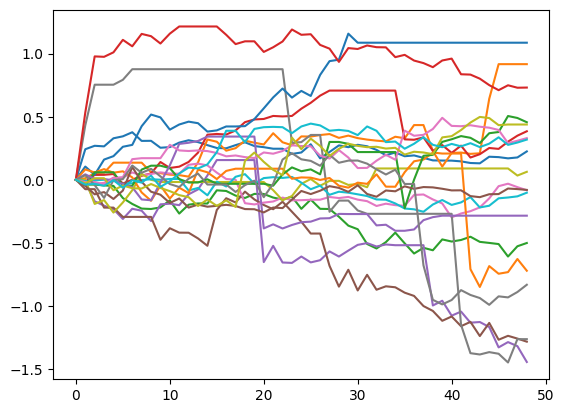

In [37]:
avg_return = compute_avg_return_print(eval_env, agent.policy, 20)
print(avg_return)

In [ ]:
weights = custom_network.get_weights()
print(weights)